# Data Augmentation Pipeline Testing
## Capstone Fall 2020
## TP Goter
This notebook is used to test the implementation of data augmentation to the existing data pipeline for our baseline supervised classification problem. We want to ensure we have a straightforward method for applying data augmentations given our existing data formats (i.e., TFRecords files) and that we can do this online. Further we want to ensure that the augmentations we choose do not result in decrease test set performance as this would indicate that our transformations are interfering with what distinguishes classes. Once the data pipeline is developed in this notebook, we will implement it as part of our supervised_classification.py script and then perform sensitivity studies to different augmentation techniques.

**Augmentation Techniques used in SimCLR:**  
1. Random Crop and Resize  - This was always done because input images were different sizes for ImageNet. We don't have this issue. So we will explore random zoom and random rotations and flips.
2. Color Distortion - This was comprised of Greyscale, color jitter and random brightness. We can incorporate channel shifts through keras easily. We could also fairly easily go to grey scale for the first three channels.
3. Gaussian Blur - This can be incorporated through Keras as well with an external function call to CV2.

In [ ]:
import pandas as pd
import tensorflow as tf
from glob import glob
import os
from matplotlib import pyplot as plt
import numpy as np
from tqdm import tqdm
#from matplotlib.cm import get_cmap
import csv
import json
import time
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.resnet50 import preprocess_input, decode_predictions
from utils import *
import cv2
import argparse

print(f'Using TensorFlow Version: {tf.__version__}')

# Set Paths
BASE_PATH = './BigEarthData'
OUTPUT_PATH = os.path.join(BASE_PATH, 'models')
TFR_PATH = os.path.join(BASE_PATH, 'tfrecords')

def get_training_dataset(training_filenames, batch_size, augment=False):
  return get_batched_dataset(training_filenames, batch_size, augment)

def get_validation_dataset(validation_filenames, batch_size):
  return get_batched_dataset(validation_filenames, batch_size)


In [2]:
training_filenames = f'{TFR_PATH}/balanced_train_0.tfrecord'
training_data = get_training_dataset(training_filenames, batch_size=8)

Filenames: ./BigEarthData/tfrecords/balanced_train_0.tfrecord


In [3]:
osi_td = tf.compat.v1.data.make_one_shot_iterator(training_data)

## Use Keras Image Preprocessing

In [5]:
def blur(img):
    return (cv2.GaussianBlur(img,(5,5),0))


/Users/tom/anaconda3/lib/python3.7/site-packages/keras_preprocessing/image/numpy_array_iterator.py:136: UserWarning: NumpyArrayIterator is set to use the data format convention "channels_last" (channels on axis 3), i.e. expected either 1, 3, or 4 channels on axis 3. However, it was passed an array with shape (8, 120, 120, 10) (10 channels).
  str(self.x.shape[channels_axis]) + ' channels).')
W1010 14:58:35.448120 4623879616 image.py:709] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
W1010 14:58:35.452072 4623879616 image.py:709] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
W1010 14:58:35.538389 4623879616 image.py:709] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
W1010 14:58:35.540652 4623879616 image.py:709] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [

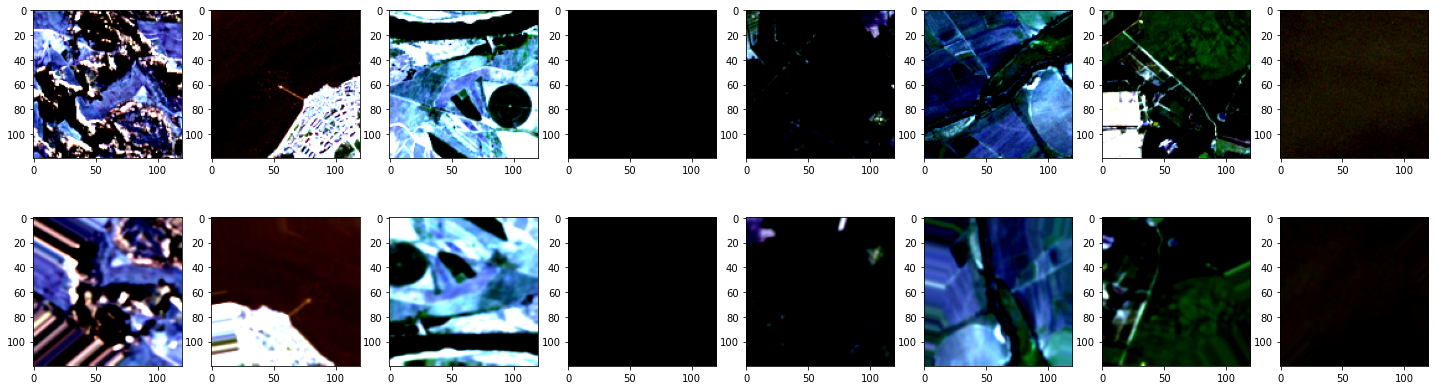

In [6]:
for batch in training_data:
    arrays = batch[0].numpy()
    datagen = image.ImageDataGenerator(
                rotation_range=180,
                width_shift_range=0.2,
                height_shift_range=0.2,
                horizontal_flip=True,
                vertical_flip=True,
                channel_shift_range=0.1,
                zoom_range=0.25,
                preprocessing_function= blur)
    aug_batch = datagen.flow(batch, batch_size=8, shuffle=False)
    fig, axes = plt.subplots(2,8,figsize=(25,7))
    axes = axes.flatten()
    for i in range(8):      
        orig_rgb = arrays[i,:,:,2::-1]
        aug_rgb = aug_batch[0][0][i,:,:,2::-1]
        axes[i].imshow(orig_rgb)
        axes[8+i].imshow(aug_rgb)
         
    break

## Summary
It appears that we can fairly easily perform different augmentations that are akin to those applied in the SimCLR paper using the Keras preprocessing techniques. Based on how the data needs to be passed and batched, we will incorporate the augmentation into our read_tfrecord function in the utils module. 

## Apply Augmentation Batchwise
If we iterate over our training data, we can apply the augmentation one batch at a time. We will use this technique to compare different augmentation methods in our supervised baseline.

W1010 15:20:42.974845 4623879616 image.py:709] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
W1010 15:20:42.978692 4623879616 image.py:709] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
W1010 15:20:43.183218 4623879616 image.py:709] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
W1010 15:20:43.185708 4623879616 image.py:709] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
W1010 15:20:43.324973 4623879616 image.py:709] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
W1010 15:20:43.327768 4623879616 image.py:709] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
W1010 15:20:43.420073 4623879616 image.py:709] Clipping in

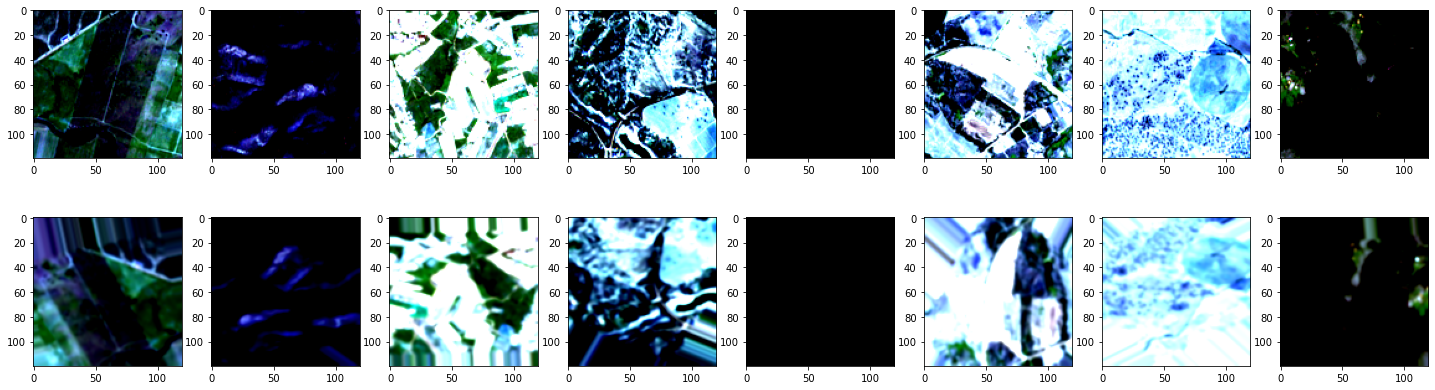

In [20]:
for batch in training_data:
    arrays = batch[0].numpy()
    datagen = image.ImageDataGenerator(
                rotation_range=180,
                width_shift_range=0.2,
                height_shift_range=0.2,
                horizontal_flip=True,
                vertical_flip=True,
                channel_shift_range=0.1,
                zoom_range=0.25,
                preprocessing_function= blur)
    aug_batch = datagen.flow(batch, batch_size=8, shuffle=False)
    fig, axes = plt.subplots(2,8,figsize=(25,7))
    axes = axes.flatten()
    for i in range(8):      
        orig_rgb = arrays[i,:,:,2::-1]
        aug_rgb = aug_batch[0][0][i,:,:,2::-1]
        axes[i].imshow(orig_rgb)
        axes[8+i].imshow(aug_rgb)
         
    break

In [27]:
len(aug_batch[0])

2